# Import Core Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import pickle

from os import listdir, walk
from os.path import isfile, join

In [2]:
from detect_peaks import detect_peaks

# Load Dataset

In [3]:
sid = '260219'
rec_date = '2019-02-26'

mypath = '../../DDC_Data/'
basepath = '../../'

acc_filepath = mypath + sid + '/' + sid + '-log_acc.csv'
df_raw = pd.read_csv(acc_filepath, header=None, names=['x','y','z','timestamp'])

bool_list = df_raw['timestamp'].str[:10] == rec_date

df1 = df_raw[bool_list]
df1 = df1.reset_index(drop=True)

xyz_cols = ['x','y','z']
g = 9.8

for c in xyz_cols:
    df1[c] = df1[c].apply(lambda x: x/g)

X_dict = df1[xyz_cols].to_dict(orient='split')

In [4]:
X_all = np.array(X_dict['data'])
X_all

array([[-0.07634571,  0.40628137,  0.87095194],
       [-0.07194821,  0.39015716,  0.89831418],
       [-0.07732294,  0.40872443,  0.89733694],
       ...,
       [-0.07158174,  0.32578245,  1.13797867],
       [-0.1048074 ,  0.22854854,  0.78129153],
       [-0.23184666,  0.26714894,  0.7236352 ]])

In [5]:
y_all = np.zeros(X_all.shape[0])

# Data Preprocessing

In [6]:
%run preprocessing.ipynb

In [7]:
print(X_all.shape, y_all.shape)

(169647, 3) (169647,)


# Labels

In [8]:
new_label_list = [0,1,2,3]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange']

# Apply PCA

In [9]:
from sklearn.decomposition import PCA

In [10]:
n_comp = 3

pca = PCA(n_components=n_comp)
X_pca = pca.fit(X_all).transform(X_all)

In [11]:
X_svm, y_svm = prepare_impure_label(X_pca, y_all)

In [12]:
print(X_svm.shape, y_svm.shape)

(169588, 180) (169588,)


# Predict

In [13]:
filename = basepath + 'model/knn_model_normal_people.pkl'

model = pickle.load(open(filename, 'rb'))

In [14]:
y_pred = model.predict(X_svm)

KeyboardInterrupt: 

In [ ]:
print(y_pred.shape)

## Evaluation

In [16]:
%run eval_score.ipynb

In [17]:
%run classifier_alg.ipynb

In [18]:
LABELS = ['sit','sleep','stand','walk']

# Combine SVM and Walk Algorithm

In [ ]:
y_pred_new = combine_2(X_svm, y_pred)

In [ ]:
y_pred_new = np.array(y_pred_new)

df1['y_pred'] = pd.Series(y_pred_new)

In [ ]:
for i in range(len(df1)):
    if(not (df1.loc[i, 'y_pred'] in [0.0,1.0,2.0,3.0])):
        keep = i
        break

In [ ]:
df_no_null = df1[:keep].copy()

df_no_null['y_pred'] = df_no_null['y_pred'].astype(int)

In [ ]:
df_no_null

In [ ]:
df_no_null['y_pred'].value_counts()

# Visualization

In [51]:
%run test_model.ipynb

In [52]:
LABELS = ['sit','sleep','stand','walk']

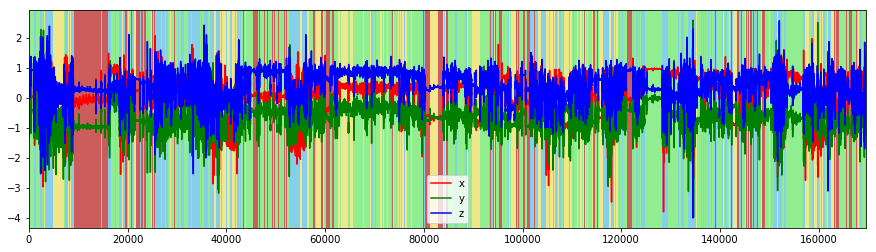

In [53]:
pred_periods = get_predicted_periods(df_no_null)
pp_all_run = postprocess_predicted(pred_periods, df_no_null)

df_no_null['y_pred'] = pd.Series(pp_all_run)
pp_periods = get_predicted_periods(df_no_null)

ax1 = df_no_null.plot(y=['x','y','z'], figsize=(15,4), color=['r','g','b'])

color_list = ['indianred','khaki','lightgreen','skyblue']   # sit, sleep, stand, walk

for i in range(len(pred_periods)):
    for item in pred_periods[i]:
        ax1.axvspan(item[0], item[1], color=color_list[i])

In [55]:
fig = ax1.get_figure()
fig.savefig(basepath + 'Graphs/all_day_260219.png', dpi=300)

# Display Table

In [ ]:
from prettytable import PrettyTable

In [ ]:
df_y = df_no_null.copy()

In [ ]:
label_period = []
period_list = [[] for i in range(len(LABELS))]

first = 0
keep = 0

for i in range(len(df_y)):
    keep_lb = df_y.loc[keep]['y_pred']

    if(keep_lb!=df_y.loc[i]['y_pred']):
        label_period.append([df_y.loc[keep]['timestamp'], df_y.loc[i-1]['timestamp'], 
                             df_y.loc[i-1]['y_pred']])

        period_list[df_y.loc[i-1]['y_pred']].append([df_y.loc[keep]['timestamp'], df_y.loc[i-1]['timestamp']])

        keep = i

In [ ]:
labels_list = ['sit', 'sleep', 'stand', 'walk']
headers = ['start', 'end', 'pred']

t = PrettyTable(headers)

for row in  
#     if(calc_sec(row[1].split(' ')[1])-calc_sec(row[0].split(' ')[1])>1):
    t.add_row([row[0], row[1], labels_list[row[2]]])

In [ ]:
print(t)

In [ ]:
print(len(label_period))

label_cnt_list = [0 for i in range(len(labels_list))]
for lb_p in label_period:
    label_i = lb_p[2]
    
    label_cnt_list[label_i] += 1

activity_changes = []
for i in range(len(labels_list)):
    activity_changes.append([labels_list[i], label_cnt_list[i]])
    
print(activity_changes)

In [ ]:
headers = ['Label', 'Activities Count']
tabl_act_chng = PrettyTable(headers)

for ac in activity_changes:
    tabl_act_chng.add_row([ac[0], ac[1]])
    
tabl_act_chng.add_row(['', ''])
tabl_act_chng.add_row(['total changes', len(label_period)])

In [ ]:
print(tabl_act_chng)

## Frequency Active <-> Inactive

In [ ]:
headers = ['Frequency', 'Activities Count']
tabl_Freq = PrettyTable(headers)
Fq1 = 0
isActive = None
if(labels_list[label_period[0][2]] == 'stand' or labels_list[label_period[0][2]] == 'walk') :
    isActive = True
else :
    isActive = False
    
for fq in label_period :
    if((labels_list[fq[2]] == 'stand' or labels_list[fq[2]] == 'walk') and isActive == False):
        Fq1 += 1
        isActive = True
    elif((labels_list[fq[2]] == 'sleep' or labels_list[fq[2]] == 'sit') and isActive == True) :
        Fq1 += 1
        isActive = False
    else :
        waste = 0

tabl_Freq.add_row(['Active <-> Inactive', Fq1])

In [ ]:
print(tabl_Freq)

## Active Inactive AC (ALL)

In [ ]:
headers = ['Label', 'Activities Count']
tabl_act = PrettyTable(headers)
inactive_table = []
active_table = []

sum = 0
sum_2 = 0
for ac in activity_changes:
    if(ac[0] == 'sit' or ac[0] == 'sleep'):
        sum += ac[1]
    else :
        sum_2 += ac[1]

tabl_act.add_row(['Inactive', sum])
tabl_act.add_row(['Active', sum_2])

In [ ]:
print(tabl_act)

# Frequency of Transition between Active and Inactive

In [ ]:
label_period

In [ ]:
headers = ['Frequency', 'Activities Count']
tabl_Freq = PrettyTable(headers)
Fq1 = 0
isActive = None
if(labels_list[label_period[0][2]] == 'stand' or labels_list[label_period[0][2]] == 'walk') :
    isActive = True
else :
    isActive = False
    
for fq in label_period :
    if((labels_list[fq[2]] == 'stand' or labels_list[fq[2]] == 'walk') and isActive == False):
        Fq1 += 1
        isActive = True
    elif((labels_list[fq[2]] == 'sleep' or labels_list[fq[2]] == 'sit') and isActive == True) :
        Fq1 += 1
        isActive = False
    else :
        waste = 0

tabl_Freq.add_row(['Active <-> Inactive', Fq1])

In [ ]:
print(tabl_Freq)

# Convert Time to String Method

In [ ]:
def convert_time_to_string(sec):
    minute = math.floor(sec/60)
    sec = int(sec%60)

    time_string = str(minute) + ':' + str(sec)
    if(sec<10):
        time_string = str(minute) + ':0' + str(sec)
    
    return time_string

# Predicted Duration

In [ ]:
total_secs = []
for i in range(len(period_list)):    
    secs = 0
    for p_i in period_list[i]:
        sec = calc_sec(p_i[1].split(' ')[1]) - calc_sec(p_i[0].split(' ')[1])
        secs += sec
    
    secs = round(secs, 3)
    total_secs.append(secs)
    
percent_secs = [round(t/np.sum(total_secs)*100, 3) for t in total_secs]

tb = PrettyTable(['Label', 'Seconds', 'Percentage'])

for i in range(len(LABELS)):
    tb.add_row([labels_list[i], convert_time_to_string(total_secs[i]), percent_secs[i]])

tb.add_row(['', '', ''])
tb.add_row(['total', convert_time_to_string(round(np.sum(total_secs), 3)), round(np.sum(percent_secs), 3)])

# Activity Durations Table

In [ ]:
print('Prediction')
print(tb)

# Bar Chart for Every 1 Hour

In [ ]:
s_idx = 0
f_idx = 1
lb_idx = 2

## Separate Each Hour

In [22]:
fivemin = 60*60
new_label_period = []

start_time = calc_sec(label_period[0][s_idx].split(' ')[1])
finish_time = calc_sec(label_period[-1][f_idx].split(' ')[1])

floor_start = start_time - (start_time%fivemin)
ceil_finish = finish_time - (finish_time%fivemin) + fivemin

# print(calc_ts(floor_start), calc_ts(ceil_finish))

tm_s = floor_start
tm_f = floor_start + fivemin
date = label_period[0][s_idx].split(' ')[0]

for prd in label_period:
    start = calc_sec(prd[s_idx].split(' ')[1])
    finish = calc_sec(prd[f_idx].split(' ')[1])
    
    if(finish>=tm_f and
      start-(start%fivemin)==tm_s):
            
        new_prd = [prd[s_idx], date + ' ' + calc_ts(tm_f), prd[lb_idx]]
        new_label_period.append(new_prd)
    
    elif(start-(start%fivemin)==tm_s and
        finish-(finish%fivemin)+fivemin==tm_f):
        new_label_period.append(prd)
        
    while(finish>=tm_f):
        tm_s += fivemin
        tm_f += fivemin
                
    if(start<tm_s):
        new_prd = [date + ' ' + calc_ts(tm_s), prd[f_idx], prd[lb_idx]]
        new_label_period.append(new_prd)

NameError: name 'calc_sec' is not defined

In [161]:
new_label_period

[['10:11:22.151', '10:11:36.408', 0],
 ['10:11:36.569', '10:11:42.68', 1],
 ['10:11:42.841', '10:11:51.848', 0],
 ['10:11:52.009', '10:12:15.639', 3],
 ['10:12:15.802', '10:12:21.426', 0],
 ['10:12:21.586', '10:12:29.783', 3],
 ['10:12:29.967', '10:13:52.871', 0],
 ['10:13:53.029', '10:15:02.626', 3],
 ['10:15:02.787', '10:15:58.695', 0],
 ['10:15:58.854', '10:16:02.231', 3],
 ['10:16:02.389', '10:17:25.605', 0],
 ['10:17:25.763', '10:18:05.605', 3],
 ['10:18:05.764', '10:18:09.139', 0],
 ['10:18:09.299', '10:18:25.523', 1],
 ['10:18:25.682', '10:18:32.749', 3],
 ['10:18:32.91', '10:18:43.67', 0],
 ['10:18:43.83', '10:19:19.333', 3],
 ['10:19:19.491', '10:19:27.364', 0],
 ['10:19:27.525', '10:19:33.148', 3],
 ['10:19:33.309', '10:19:58.846', 0],
 ['10:19:59.008', '10:20:06.877', 1],
 ['10:20:07.039', '10:20:52.809', 3],
 ['10:20:52.97', '10:21:05.177', 0],
 ['10:21:05.338', '10:22:12.006', 3],
 ['10:22:12.165', '10:22:14.737', 0],
 ['10:22:14.896', '10:22:48.465', 3],
 ['10:22:48.627',

In [164]:
label_dict = {
    'sit': 0,
    'sleep': 1,
    'stand': 2,
    'walk': 3
}

# Get Active/Inactive Count and Transition Count

In [203]:
all_periods_label = []
all_act_count = []
all_trans = []

for t_i in range(int(floor_start), int(ceil_finish), fivemin):
    period_lb = [0 for i in range(len(LABELS))]
    act_count = [0 for i in range(2)]
    trans = 0
    
    for p_i in range(len(new_label_period)):
        prd = new_label_period[p_i]
        
        if(calc_sec(prd[s_idx])>=t_i and calc_sec(prd[f_idx])<=t_i+fivemin):
            period_lb[prd[lb_idx]] += calc_sec(prd[f_idx])-calc_sec(prd[s_idx])
            period_lb[prd[lb_idx]] = round(period_lb[prd[lb_idx]], 3)
            
            # count activities
            if(prd[lb_idx]==label_dict['sit'] or prd[lb_idx]==label_dict['sleep']):
                act_count[0] += 1
            else:
                act_count[1] += 1
                
            # count transitions
            if(p_i+1<len(new_label_period)):
                next_prd = new_label_period[p_i+1]
                
                if((prd[lb_idx]==label_dict['sit'] or prd[lb_idx]==label_dict['sleep']) and
                  (next_prd[lb_idx]==label_dict['stand'] or next_prd[lb_idx]==label_dict['walk'])):
                    trans += 1
                if((prd[lb_idx]==label_dict['stand'] or prd[lb_idx]==label_dict['walk']) and
                  (next_prd[lb_idx]==label_dict['sit'] or next_prd[lb_idx]==label_dict['sleep'])):
                    trans += 1
            
    all_periods_label.append(period_lb)
    all_act_count.append(act_count)
    all_trans.append(trans)

In [251]:
active_cols = ['inactive', 'active']
columns = labels_list
onehour = 60

df_all = pd.DataFrame(all_periods_label, columns=columns)

for i in range(2):
    df_all[active_cols[i]] = pd.Series(np.transpose(all_act_count)[i])
    
df_all['total activities'] = df_all['inactive'] + df_all['active']
    
df_all['transition'] = pd.Series(all_trans)

df_all['minutes per action'] = onehour/df_all['transition']
df_all['minutes per action'] = round(df_all['minutes per action'], 3)
df_all['minutes per action'] = df_all['minutes per action'].apply(lambda x: 
                                                                 convert_time_to_string(x*60))

In [208]:
onemin = 60
df_all[labels_list] = df_all[labels_list].apply(lambda x: x/onemin)

In [252]:
df_all

,sit,sleep,stand,walk,inactive,active,total activities,transition,minutes per action
0,1849.258,48.529,16.864,996.900,23,17,40,31,1:56
1,1482.881,258.059,65.638,1769.759,77,71,148,108,0:33
2,1856.844,63.721,28.902,1639.527,32,38,70,58,1:02
3,315.181,630.518,4.814,2642.399,26,19,45,34,1:45
4,1329.090,924.505,81.401,1248.483,58,46,104,67,0:53
5,1417.849,515.220,61.125,1588.994,65,42,107,71,0:50
6,948.348,353.668,44.505,2236.804,56,47,103,71,0:50
7,801.609,187.342,45.381,1620.786,39,37,76,55,1:05


## Plot Bar Graph

In [145]:
test_subj = 'Indy-260219'

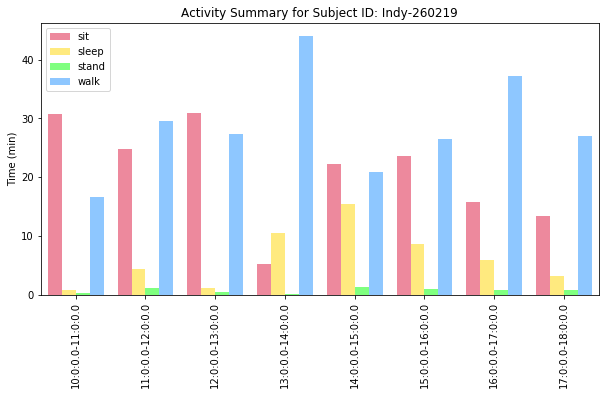

In [218]:
pos = list(range(len(df_all['sit'])))
width = 0.2
colors = ['crimson','gold','lime','dodgerblue']

fig, ax = plt.subplots(figsize=(10,5))

for i in range(len(LABELS)):
    plt.bar([p + i*width for p in pos],
            df_all[labels_list[i]],
            width,
            alpha=0.5,
            color=colors[i],
            label=labels_list[i])
    
ax.set_xticks([p + 1.5 * width for p in pos])

xtick_labels = [calc_ts(floor_start + i*fivemin) + '-' + calc_ts(floor_start + (i+1)*fivemin)
                for i in range(len(df_all))]
ax.set_xticklabels(xtick_labels)
plt.xticks(rotation=90)

ax.set_ylabel('Time (min)')

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.legend(loc='upper left')
plt.title('Activity Summary for Subject ID: ' + test_subj)

plt.show()

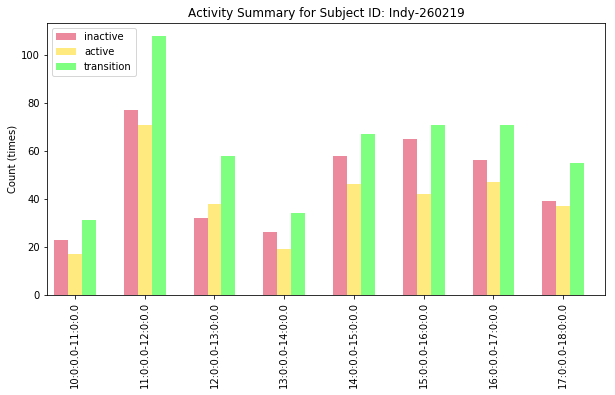

In [219]:
cols = ['inactive', 'active', 'transition']

fig, ax = plt.subplots(figsize=(10,5))

for i in range(len(cols)):
    plt.bar([p + i*width for p in pos],
            df_all[cols[i]],
            width,
            alpha=0.5,
            color=colors[i],
            label=cols[i])
    
ax.set_xticks([p + 1 * width for p in pos])

xtick_labels = [calc_ts(floor_start + i*fivemin) + '-' + calc_ts(floor_start + (i+1)*fivemin)
                for i in range(len(df_all))]
ax.set_xticklabels(xtick_labels)
plt.xticks(rotation=90)

ax.set_ylabel('Count (times)')

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.legend(loc='upper left')
plt.title('Activity Summary for Subject ID: ' + test_subj)

plt.show()